In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import japanize_matplotlib 

import glob
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import networkx as nx

%matplotlib inline 

In [35]:
from pillow_heif import register_heif_opener
from PIL import Image
import os

# HEICを開けるように登録
register_heif_opener()

input_root = 'resistor_images'
output_root = 'resistor_images_jpg'

# 再帰的にすべてのフォルダ・ファイルを探索
for root, dirs, files in os.walk(input_root):
    for file in files:
        if file.lower().endswith(".heic"):
            # 入力パスと出力パスを構築
            input_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, input_root)  # サブフォルダ構造を保つ
            output_dir = os.path.join(output_root, relative_path)
            os.makedirs(output_dir, exist_ok=True)

            # 出力ファイル名（.jpgに変換）
            jpg_filename = os.path.splitext(file)[0] + ".jpg"
            output_path = os.path.join(output_dir, jpg_filename)

            # 画像を開いて保存
            try:
                image = Image.open(input_path)
                image.save(output_path, format="JPEG")
                print(f"✅ {input_path} → {output_path}")
            except Exception as e:
                print(f"❌ エラー: {input_path}: {e}")


In [36]:
from PIL import Image, ImageEnhance
import os

input_root = 'img/resistor_images_jpg'
output_root = 'img/resistor_images_augmented'

# 保存用接尾辞（各種Augmentation名）
suffixes = {
    "original": "",
    "flip": "_flip",
    "rotate": "_rotate",
    "bright": "_bright",
    "dark": "_dark"
}

# すべてのフォルダ・ファイルを探索
for root, dirs, files in os.walk(input_root):
    for file in files:
        if file.lower().endswith(".jpg"):
            input_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, input_root)
            output_dir = os.path.join(output_root, relative_path)
            os.makedirs(output_dir, exist_ok=True)

            try:
                img = Image.open(input_path)

                # 拡張セット
                augmentations = {
                    "original": img,
                    "flip": img.transpose(Image.FLIP_LEFT_RIGHT),
                    "rotate": img.rotate(180),
                    "bright": ImageEnhance.Brightness(img).enhance(1.5),
                    "dark": ImageEnhance.Brightness(img).enhance(0.7)
                }

                # 保存
                base_filename = os.path.splitext(file)[0]
                for key, aug_img in augmentations.items():
                    suffix = suffixes[key]
                    output_filename = f"{base_filename}{suffix}.jpg"
                    output_path = os.path.join(output_dir, output_filename)
                    aug_img.save(output_path, format="JPEG")
                    print(f"✅ 保存: {output_path}")

            except Exception as e:
                print(f"❌ エラー: {input_path}: {e}")


✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7455.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7455_flip.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7455_rotate.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7455_bright.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7455_dark.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7457.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7457_flip.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7457_rotate.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7457_bright.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7457_dark.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7456.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7456_flip.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7456_rotate.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7456_bright.jpg
✅ 保存: img/resistor_images_augmented/23KR/right/IMG_7456_dark.jpg
✅ 保存: img/resistor_images_au

In [56]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# パラメータ
IMG_SIZE = 64
DATA_DIR = 'img/resistor_images_augmented'

# ラベル名を取得（フォルダ名）
labels = sorted(os.listdir(DATA_DIR))
label_to_index = {label: i for i, label in enumerate(labels)}

# データ読み込み
X = []
y = []

for label in labels:
    label_dir = os.path.join(DATA_DIR, label)
    for subfolder, _, files in os.walk(label_dir):
        for file in files:
            if file.endswith('.jpg'):
                img_path = os.path.join(subfolder, file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize((IMG_SIZE, IMG_SIZE))
                    X.append(np.array(img))
                    y.append(label_to_index[label])
                except:
                    print(f"❌ 読み込み失敗: {img_path}")

X = np.array(X) / 255.0  # 正規化
y = to_categorical(y)    # One-hot encoding

# データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"✅ データ形状: {X_train.shape}, {y_train.shape}")


✅ データ形状: (437, 64, 64, 3), (437, 5)


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# モデル構築
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')  # クラス数に合わせる
])

# コンパイル
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# コールバック（早期終了）
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 学習
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping]
)

# モデル保存
model.save('resistor_model.h5')
print("✅ モデル学習と保存が完了しました")


Epoch 1/30


/Users/yasuo/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.2127 - loss: 1.6523 - val_accuracy: 0.2074 - val_loss: 1.6143
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2239 - loss: 1.6115 - val_accuracy: 0.2021 - val_loss: 1.6138
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1658 - loss: 1.6282 - val_accuracy: 0.1649 - val_loss: 1.6107
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2254 - loss: 1.6073 - val_accuracy: 0.1649 - val_loss: 1.6129
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2004 - loss: 1.6138 - val_accuracy: 0.1755 - val_loss: 1.6106
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2667 - loss: 1.6051 - val_accuracy: 0.1543 - val_loss: 1.6118
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2279 - loss: 1.6056 - val_accuracy: 0.2181 - val_loss: 1.6166
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2204 - loss: 1.5939 - val_accuracy: 0.2021 - val_loss: 1.

✅ モデル学習と保存が完了しました


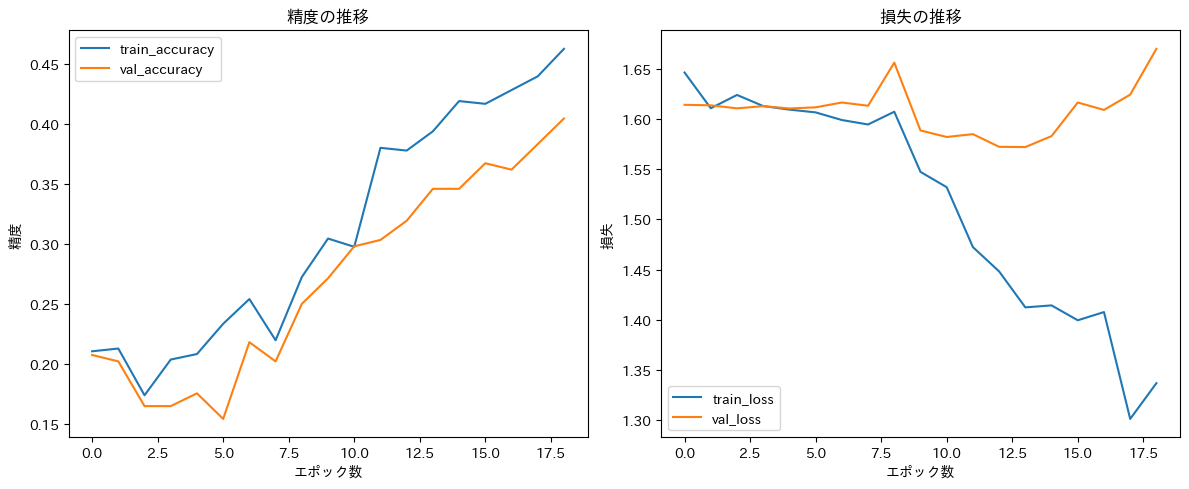

In [58]:
import matplotlib.pyplot as plt

# 精度の推移
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('エポック数')
plt.ylabel('精度')
plt.title('精度の推移')
plt.legend()

# 損失の推移
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('エポック数')
plt.ylabel('損失')
plt.title('損失の推移')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


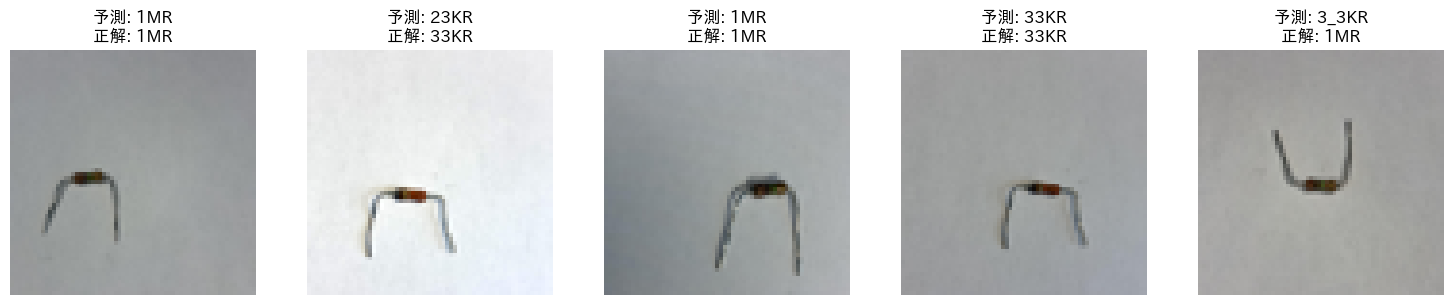

In [59]:
import random

# ラベル辞書（index → ラベル名）を再構成
index_to_label = {i: label for label, i in label_to_index.items()}

# ランダムに予測して表示
n = 5
plt.figure(figsize=(15, 3))
for i in range(n):
    idx = random.randint(0, len(X_val) - 1)
    img = X_val[idx]
    true_label = np.argmax(y_val[idx])
    
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_label = np.argmax(pred[0])
    
    plt.subplot(1, n, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'予測: {index_to_label[pred_label]}\n正解: {index_to_label[true_label]}')

plt.tight_layout()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


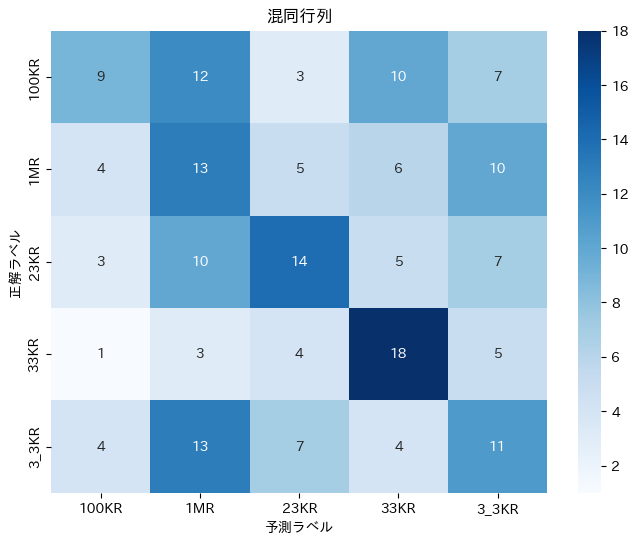

              precision    recall  f1-score   support

       100KR       0.43      0.22      0.29        41
         1MR       0.25      0.34      0.29        38
        23KR       0.42      0.36      0.39        39
        33KR       0.42      0.58      0.49        31
       3_3KR       0.28      0.28      0.28        39

    accuracy                           0.35       188
   macro avg       0.36      0.36      0.35       188
weighted avg       0.36      0.35      0.34       188



In [60]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 予測と正解を取得
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# 混同行列
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('予測ラベル')
plt.ylabel('正解ラベル')
plt.title('混同行列')
plt.show()

# 詳細な分類レポート
print(classification_report(y_true_labels, y_pred_labels, target_names=labels))
